# Lab Vision Sytems: Session 2

# Convolutional Networks (CNNs)

In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

plt.style.use('seaborn')

In [ ]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
torch.cuda.is_available()

True

### Pipeline
  - Data:
      - Load dataset
      - DataLoader
      - Visualize dataset samples
  - Design Model:
      - Model Architecture
      - Forward Pass
  - Define Loss Function
  - Define Optimizer
  - Train:
      - Forward Pass (compute activations and loss)
      - Backward Pass (compute gradients)
      - Update Weights

## Dataset and DataLoader

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [5]:
# Fitting data loaders for iterating
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

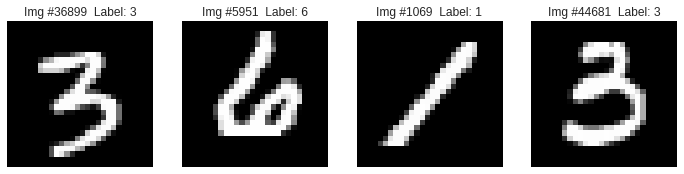

In [8]:
N_IMGS = 4
fig, ax = plt.subplots(1, N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    #img = train_dataset[n][0].numpy().transpose(1,2,0)
    img = train_dataset[n][0].permute(1, 2, 0)
    label_idx = train_dataset[n][1]
    
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {label_idx}")
    ax[i].axis("off")
plt.show()

In [12]:
print(len(train_dataset))

60000


In [23]:
it = iter(train_loader)
current_batch = next(it)
print(current_batch[0].shape) # batch x
print(len(current_batch[1])) # batch y

torch.Size([64, 1, 28, 28])
64


## Model

In [9]:
class CNN(nn.Module):
    """ 
    Varation of LeNet: a simple CNN model
    for handwritten digit recognition
    """
    def __init__(self):
        super().__init__()
        
        conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        relu1 = nn.ReLU()
        maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.layer1 = nn.Sequential(
                conv1, relu1, maxpool1
        )
      
        conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        relu2 = nn.ReLU()
        maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.layer2 = nn.Sequential(
                conv2, relu2, maxpool2
        )
        
        in_dim = 32 * 4 * 4 # (C,H,W) => C*H*W
        self.fc = nn.Linear(in_features=in_dim, out_features=10)
        
        
    def forward(self, x):
        cur_b_size = x.shape[0]
        
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        # Before applying MLP we have to flatten output from CNN. 
        # In this case we are flattening like this: (B, 32, 4 ,4 ) -> (B, 32 * 4 * 4)
        out2_flat = out2.view(cur_b_size, -1)
        y = self.fc(out2_flat)
        return y
    
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [10]:
cnn = CNN()
params = count_model_params(cnn)

In [11]:
cnn

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [12]:
params

18378

## Training

In [13]:
LR = 3e-4
EPOCHS = 10

In [14]:
EVAL_FREQ = 1
SAVE_FREQ = 10

In [15]:
stats = {
    "epoch": [],
    "train_loss": [],
    "train_accuracy": [],
    "eval_loss": [],
    "eval_accuracy": []
}

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
cnn = cnn.to(device)

In [18]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

In [19]:
@torch.no_grad()
def eval_model(model):
    """ Computing model accuracy """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds==labels)[0])
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss

In [20]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return

In [21]:
def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

In [22]:
for epoch in range(EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    train_total = 0
    train_correct = 0
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = cnn(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Accuracy per epoch
        preds = torch.argmax(outputs, dim=1)
        train_correct += len(torch.where(preds==labels)[0])
        train_total += len(labels)
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    train_epoch_loss = np.mean(loss_list)
    train_accuracy = train_correct / train_total * 100
    stats["epoch"].append(epoch)
    stats["train_loss"].append(train_epoch_loss)
    stats["train_accuracy"].append(train_accuracy)
    
    # evaluating model
    if epoch % EVAL_FREQ == 0:
        eval_accuracy, eval_epoch_loss = eval_model(cnn)  
        #print(f"Accuracy at epoch {epoch}: {round(accuracy, 2)}%")
    else:   
        eval_accuracy, eval_epoch_loss = -1, -1
        
    stats["eval_accuracy"].append(eval_accuracy)
    stats["eval_loss"].append(eval_epoch_loss)
    
    # saving checkpoint
    #if epoch % SAVE_FREQ == 0:
        #save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)

Epoch 10 Iter 938: loss 0.04425. : 100%|██████████| 938/938 [00:07<00:00, 128.79it/s]


In [26]:
epochs = np.array(stats["epoch"])
train_loss = np.array(stats["train_loss"])
train_accuracy = np.array(stats["train_accuracy"])

eval_loss = np.array(stats["eval_loss"])
eval_accuracy = np.array(stats["eval_accuracy"])
eval_idx = np.where(eval_loss != -1)[0]

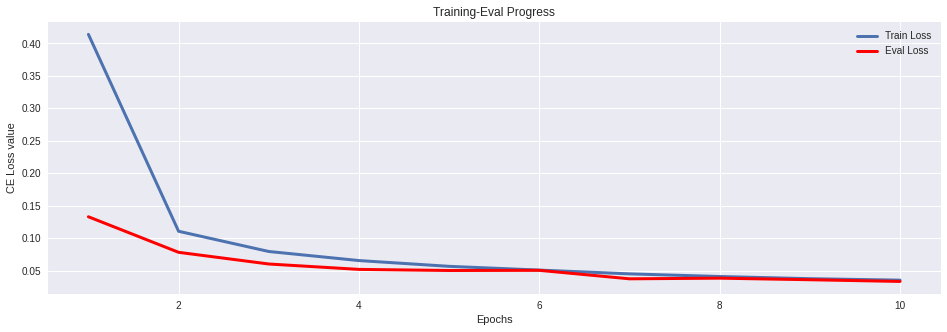

In [40]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,5)


ax.plot(epochs+1, train_loss, label="Train Loss", linewidth=3)
ax.plot(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", label="Eval Loss", linewidth=3)
#ax.scatter(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", s=100, marker="x")
ax.legend(loc="best")
ax.set_xlabel("Epochs")
ax.set_ylabel("CE Loss value")

ax.set_title("Training-Eval Progress")

plt.show()

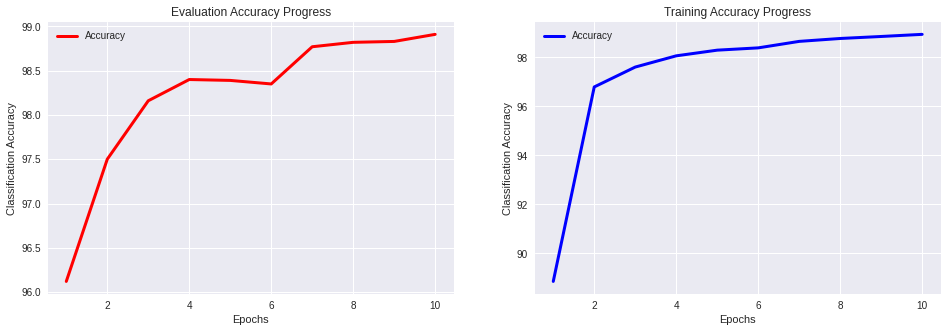

In [41]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

ax[0].plot(epochs[eval_idx]+1, eval_accuracy[eval_idx], c="red", label="Accuracy", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Classification Accuracy")
ax[0].set_title("Evaluation Accuracy Progress")

ax[1].plot(epochs+1, train_accuracy, c="blue", label="Accuracy", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Classification Accuracy")
ax[1].set_title("Training Accuracy Progress")

plt.show()

---

# References
 - https://www.deeplearningbook.org/
 - http://cs231n.stanford.edu/
 - https://towardsdatascience.com/all-you-want-to-know-about-deep-learning-8d68dcffc258
 - https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
 - https://github.com/vdumoulin/conv_arithmetic
 